Size of data set 8036


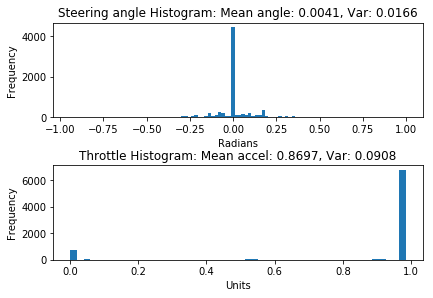

In [9]:
#Data exploration
import random
import cv2
import numpy as np
import pandas as pd
import pandas as pd
import cv2
import matplotlib.pyplot as plt

#Load data
d_f = pd.read_csv('data/driving_log.csv')

def hist_plot(d_f):
    print("Size of data set", len(d_f))
    #Get steering and accelaration details
    steer_rad= d_f['steering'].tolist()
    throttle = d_f['throttle'].tolist()
    #Mean
    ave_steer = np.mean(steer_rad)
    var_steer = np.var(steer_rad)
    #Variance
    ave_throt = np.mean(throttle)
    var_throt =np.var(throttle)

    #Plot histograms
    f, axarr = plt.subplots(2, 1)
    axarr[0].hist(steer_rad, bins=100),axarr[0].set_title("Steering angle Histogram: Mean angle: {0:.4f}, Var: {1:.4f}".format(ave_steer, var_steer)),axarr[0].set_xlabel("Radians"), axarr[0].set_ylabel("Frequency")
    axarr[1].hist(throttle, bins=50),axarr[1].set_title("Throttle Histogram: Mean accel: {0:.4f}, Var: {1:.4f}".format(ave_throt, var_throt)),axarr[1].set_xlabel("Units"), axarr[1].set_ylabel("Frequency")
    plt.tight_layout(pad=0.2, w_pad=0.1, h_pad=0.1)
    plt.show()
    %matplotlib inline 
#Display histograms
hist_plot(d_f)

Reflection on data inspection:

1. As can be seen the data set is highly skewed, with angle 0.0 comprising most of the data set.
2. There isn't much information given on acceleration with regards to the data set

The data is therefore corrected by cutting out most frames giving off an angle of 0.0

In [10]:
#Count number of 0.0 steering angles
acc_zero = d_f['steering']
non_zero  = np.count_nonzero(acc_zero)
total_zero = len(acc_zero) - non_zero
print("Total number of zero acceleration entries: {0}, total number of other entries: {1}".format(total_zero, non_zero))

Total number of zero acceleration entries: 4361, total number of other entries: 3675


Size of data set 3940


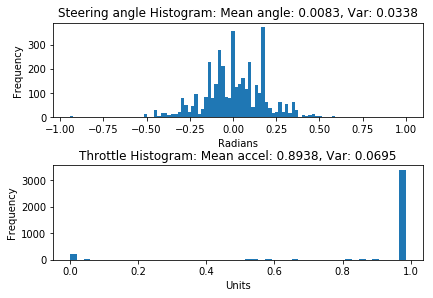

In [12]:
#Drop 90% of zero angle data
drop = int(0.1*total_zero)

#Get non-zero and zero entries
df_n = d_f[d_f.steering != 0]
df_z = d_f[d_f.steering == 0]
df_z = df_z.ix[:drop]

#Augment new entries with non-zero angle entries
new_dataset = pd.concat([df_z, df_n])
hist_plot(new_dataset)
#new_dataset = d_f

In [13]:
"""
Data augmentation: 
"""
from sklearn.preprocessing import normalize
#Size of resized images
new_size_col,new_size_row = 64, 64

def bright_aug(img):
    # 1 Brightness augmentation
    img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    r_bright = .25+np.random.uniform()
    img[:,:,2] = img[:,:,2]*r_bright
    img = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
    return img

def trans_image(image,steer,h_range, v_range):
    #.2 Horizontal and vertical shifts, each pixel shift to the left corresponds to 
    # an angle displacement of 0.002 degrees. This is subtracted to the left steering angle and 
    # added to the right steering angle
    
    #Make sure steering range is even number!
    #Horizontal shift
    rows,cols, _ = image.shape

    tr_x = random.randint(-h_range//2, h_range//2)
    steer_ang = steer+(tr_x*.2)
    
    #Vertical shift
    tr_y = random.randint(-v_range//2, v_range//2)
    
    #Affine transform matrix
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))
    #image_tr = cv2.cvtColor(image_tr,cv2.COLOR_BGR2RGB)
    return image_tr,steer_ang

def hor_flip(img, steer_ang):
    #.3 Flip images to simulate driving in opposite direction
    img=cv2.flip(img,1)
    #img= cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    return img, -steer_ang

#Preprocess data before training network
#Image preprocessing
#.1 Crop 1/5 of images: I.e. to remove horizon
#.2 Rescale image to 64 by 64: To speed up training
def prepImage(img):
    #Get rid of top 1/5 of image, and bottom 25 pixels
    shape = img.shape
    img = img[math.floor(shape[0]/4):shape[0]-25, 0:shape[1]]
    Y_channel = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.resize(Y_channel[:,:,0],(new_size_col,new_size_row), interpolation=cv2.INTER_AREA)
    return img

In [14]:
import math
def data_aug_gen(d_frame):
    #Generate 3 images --> From test set
    #Generate 3 same images --> Shading variation
    #-----------------------------------------
    #Generate all above images, flipped vertically
    #Total data set  = *12
    
    #Line data is extracted from pd data frame
    rand_p = np.random.randint(3)

    #Shift angles for non-centered camera angles
    if (rand_p == 0):
        path_file = d_frame['left'][0].strip()
        shift_ang = .25
    if (rand_p == 1):
        path_file = d_frame['center'][0].strip()
        shift_ang = 0.
    if (rand_p == 2):
        path_file = d_frame['right'][0].strip()
        shift_ang = -.25
    
    #get corresponding steering angle for center camera
    steer = d_frame['steering'][0] + shift_ang
    #read in image
    image = cv2.imread("data/"+path_file)
    #image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    
    #image, steer= trans_image(image,steer,100, 10)
    
    #augment image brightness randomly
    aug = np.random.randint(2)
    if aug == 1:
        image =  bright_aug(image)
    
    #preprocess image data, make image 64 by 64
    image = prepImage(image)
    image = np.array(image)
    
    #flip image randomly
    ind_flip = np.random.randint(2)
    
    if ind_flip==1:
        image,steer = hor_flip(image, steer)
    
    return image,steer

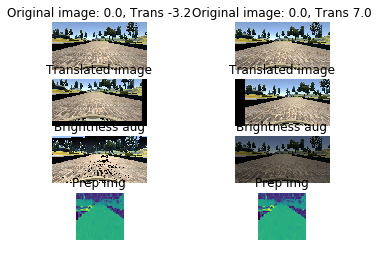

In [15]:
#Data exploration using augmented data set
#read in 5 images from img folder
test_5 = d_f.head(5) 
t_images = []
for i in range(0, len(test_5)):
    img = cv2.imread(("data/"+test_5['center'][i]))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    t_images.append(img)

#Original angles:
aa1 = d_f['steering'][0]
aa2 = d_f['steering'][1]

#Test for brightness augmentation
after_0 = bright_aug(t_images[0])
after_1 = bright_aug(t_images[1])

tr1, a1 = trans_image(t_images[0],d_f['steering'][0],100,40)
tr2, a2 = trans_image(t_images[1],d_f['steering'][1],100,40)

im_flip1 = prepImage(t_images[0])
im_flip2 = prepImage(t_images[0])
 

# Visualizations will be shown in the notebook.
f, axarr = plt.subplots(4, 2)
axarr[0, 0].imshow(t_images[0]),axarr[0, 0].set_title("Original image: {}, Trans {}".format(aa1, a1)),axarr[0, 0].axis('off') 
axarr[0, 1].imshow(t_images[1]), axarr[0, 1].set_title("Original image: {}, Trans {}".format(aa2, a2)),axarr[0, 1].axis('off') 
axarr[1, 0].imshow(tr1), axarr[1, 0].set_title("Translated image"), axarr[1, 0].axis('off') 
axarr[1, 1].imshow(tr2), axarr[1, 1].set_title("Translated image"), axarr[1, 1].axis('off') 
axarr[2, 0].imshow(after_0), axarr[2, 0].set_title("Brightness aug"), axarr[2, 0].axis('off') 
axarr[2, 1].imshow(after_1), axarr[2, 1].set_title("Brightness aug"), axarr[2, 1].axis('off') 
axarr[3, 0].imshow(im_flip1), axarr[3, 0].set_title("Prep img"), axarr[3, 0].axis('off') 
axarr[3, 1].imshow(im_flip2), axarr[3, 1].set_title("Prep img"), axarr[3, 1].axis('off') 
#plt.tight_layout(pad=0.2, w_pad=0.1, h_pad=0.1)
plt.show()
%matplotlib inline   

In [16]:
#Shuffle data to prepare for training
new_dataset= new_dataset.sample(frac=1).reset_index(drop=True)

![alt text](NVIDIA_end_to_end.png "Title")

Size of data set 2758


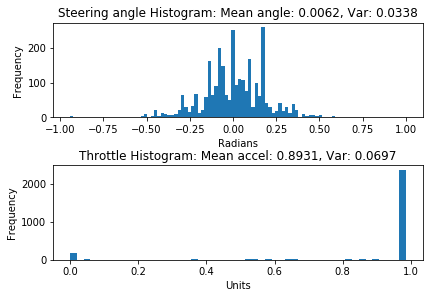

Size of data set 1182


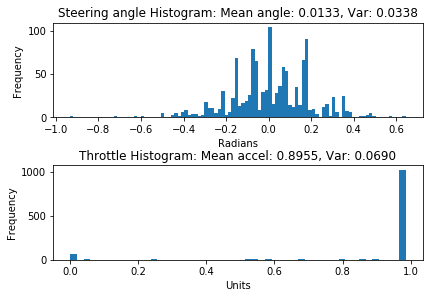

In [17]:
#Split data into train and test sets
from sklearn.model_selection import train_test_split
train, test = train_test_split(new_dataset, test_size = 0.30)

#Display new data set stats
hist_plot(train)
hist_plot(test)

In [18]:
#Generator for training 
#Height and width of images
height =64
width =64

def generate_train_from_PD(data, batch_s=64):
    while 1:
        x_img = []
        y_ang = []
        for i in range(batch_s):
            i_line = np.random.randint(len(data))
            line_data = data.iloc[[i_line]].reset_index()
            x,y = data_aug_gen(line_data)
            #x = cv2.cvtColor(x,cv2.COLOR_BGR2RGB)
            x_img.append(x)
            y_ang.append(y)
        
        x_img = np.asarray(x_img).reshape(batch_s, 64, 64, 1)
        y_ang  = np.asarray(y_ang).reshape(batch_s, 1) 
        yield x_img, y_ang
        

def generate_valid_from_PD(data, batch_s=32): 
    while 1:
        x_img = []
        y_ang = []
        for i in range(batch_s):
            i_line = np.random.randint(len(data))
            line_data = data.iloc[[i_line]].reset_index()
            #read line data from dataframe
            path_file = line_data['center'][0].strip()
            image = cv2.imread("data/"+path_file)
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) 
            x = prepImage(image)
            y = line_data['steering'][0]
            y = np.array([[y]])
            x_img.append(x)
            y_ang.append(y)
            
        x_img = np.asarray(x_img).reshape(batch_s, 64, 64, 1)
        y_ang  = np.asarray(y_ang).reshape(batch_s, 1)    
        yield x_img, y_ang

Size of test data 1182
Steer angle shape:  (1, 1)
(64, 64, 1)


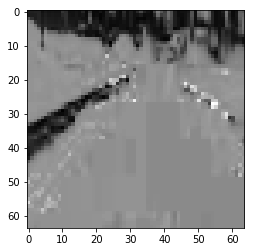

In [19]:
#Test out valid generators
print("Size of test data", len(test))
test_generator = generate_valid_from_PD(test, 1)
#for i in range(1):
#    next(test_generator)
    
img,steer = next(test_generator)
print("Steer angle shape: ",steer.shape)
#Test out images
#print("Steering shape",steer)
plt.imshow(img[0].reshape(64, 64), cmap = "gray")
print(img[0].shape)
plt.show()

Size of training data 2758
Batch shape:  (32, 64, 64, 1)
Steer angle shape:  (32, 1)


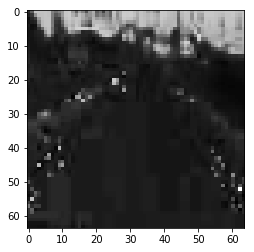

In [20]:
#Test out train generators
print("Size of training data", len(train))

train_generator = generate_train_from_PD(train, 32)
for i in range(1):
    next(train_generator)

img,steer = (next(train_generator))
print("Batch shape: ",img.shape)
print("Steer angle shape: ",steer.shape)
#print('steering angle', steer)

plt.imshow(img[0].reshape(64, 64), cmap = "gray")

In [21]:
#Final keras model based on NVDIA end to end soltn
#.3 Use Keras generator so not all data is kept in memory
#.4 Lambda layer in keras to normalize intensities between -.5 and .5.
#.5 We will utilize kera’s generator function to sample images such 
#that images with lower angles have lower probability of getting represented in the data set

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation,Lambda
from keras.layers import Input, ELU
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras.layers import Convolution2D, MaxPooling2D, Flatten
from keras import initializations
new_size_row = 64
new_size_col = 64
input_shape = (new_size_row, new_size_col, 1)
filter_size = 3

#NVIDIA en
pool_size = (2,2)
model = Sequential()
#model.add(MaxPooling2D(pool_size=pool_size,input_shape=input_shape))
model.add(Lambda(lambda x: x/255.-0.5,input_shape=input_shape))

model.add(Convolution2D(3,1,1,
                        border_mode='valid',
                        name='conv0', init='he_normal'))
model.add(ELU())

model.add(Convolution2D(32,filter_size,filter_size,
                        border_mode='valid',
                        name='conv1', init='he_normal'))
model.add(ELU())
model.add(Convolution2D(32,filter_size,filter_size,
                        border_mode='valid',
                        name='conv2', init='he_normal'))
model.add(ELU())
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.5))

model.add(Convolution2D(64,filter_size,filter_size,
                        border_mode='valid',
                        name='conv3', init='he_normal'))
model.add(ELU())

model.add(Convolution2D(64,filter_size,filter_size,
                        border_mode='valid',
                        name='conv4', init='he_normal'))
model.add(ELU())
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Dropout(0.5))


model.add(Convolution2D(128,filter_size,filter_size,
                        border_mode='valid',
                        name='conv5', init='he_normal'))
model.add(ELU())
model.add(Convolution2D(128,filter_size,filter_size,
                        border_mode='valid',
                        name='conv6', init='he_normal'))
model.add(ELU())
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.5))


model.add(Flatten())

model.add(Dense(512,name='hidden1', init='he_normal'))
model.add(ELU())
model.add(Dropout(0.5))
model.add(Dense(64,name='hidden2', init='he_normal'))
model.add(ELU())
model.add(Dropout(0.5))
model.add(Dense(16,name='hidden3',init='he_normal'))
model.add(ELU())
model.add(Dropout(0.5))
model.add(Dense(1, name='output', init='he_normal'))
"""

model = Sequential()
model.add(Lambda(lambda x: x/255.-0.5,input_shape=input_shape))
# 1st Layer - Add a flatten layer
model.add(Convolution2D(32, 3, 3, input_shape=input_shape))
#Conv layer
model.add(Flatten(input_shape=(64, 64, 3)))
# 2nd Layer - Add a fully connected layer
# 3rd Layer - Add a ReLU activation layer
model.add(Activation('relu'))
model.add(Dropout(0.5))
# 4th Layer - Add a fully connected layer
model.add(Dense(43))
# 5th Layer - Add a ReLU activation layer
model.add(Dense(1, name='output', init='he_normal'))
"""
model.summary()

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 64, 64, 1)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
conv0 (Convolution2D)            (None, 64, 64, 3)     6           lambda_1[0][0]                   
____________________________________________________________________________________________________
elu_1 (ELU)                      (None, 64, 64, 3)     0           conv0[0][0]                      
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 62, 62, 32)    896         elu_1[0][0]                      
___________________________________________________________________________________________

In [22]:
#Conv RNN implementation

In [23]:
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam,
          loss='mse')

In [ ]:
#Training loop
val_size = len(test)
batch_s = 128
train_aug = len(train)

print(train_aug)

train_gen =generate_train_from_PD(train, 32)
valid_s_generator = generate_valid_from_PD(test, 32)

history = model.fit_generator(generator = train_gen,
            samples_per_epoch=batch_s*200, nb_epoch=20,validation_data=valid_s_generator,
                        nb_val_samples=val_size*20)

2758
Epoch 1/20
25600/25600 [==============================] - 162s - loss: 1.6970 - val_loss: 0.0482

In [25]:
#Save final model as specified in Udacity ruberic
# serialize model to JSON
model_json = model.to_json()
with open("../../model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save('../../model.h5') 
print("Saved model to disk")
'''
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
print "%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100)'''

Saved model to disk


'\n# load json and create model\njson_file = open(\'model.json\', \'r\')\nloaded_model_json = json_file.read()\njson_file.close()\nloaded_model = model_from_json(loaded_model_json)\n# load weights into new model\nloaded_model.load_weights("model.h5")\nprint("Loaded model from disk")\n \n# evaluate loaded model on test data\nloaded_model.compile(loss=\'binary_crossentropy\', optimizer=\'rmsprop\', metrics=[\'accuracy\'])\nscore = loaded_model.evaluate(X, Y, verbose=0)\nprint "%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100)'